In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

# Load the 'food101' dataset, shuffle files, and load with info
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

In [ ]:
train_ds,valid_ds =ds["train"],ds["validation"]

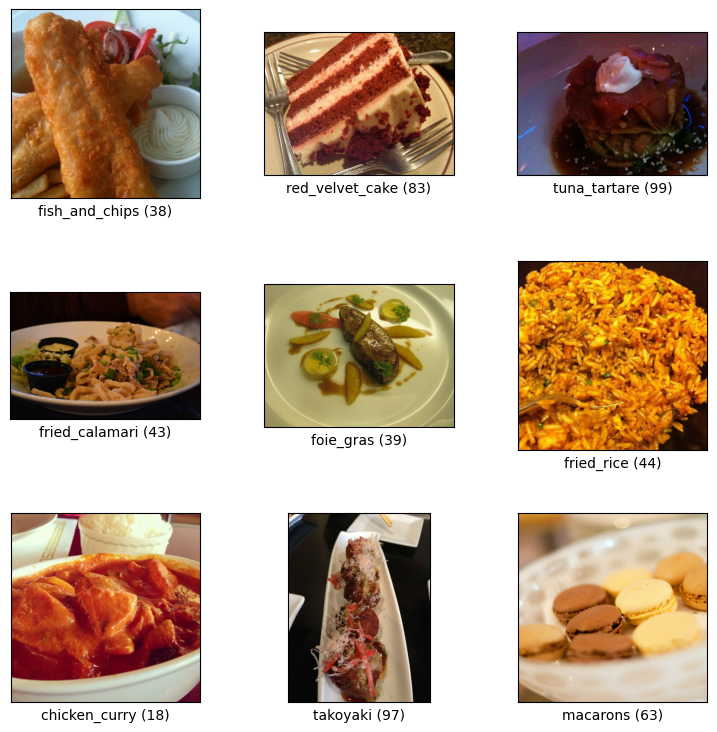

In [ ]:
fig = tfds.visualization.show_examples(train_ds, ds_info)

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55

# Preprocess the training dataset
train_ds = train_ds.map(
    lambda image, label: (
        tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]),  # Resize the image
        tf.cast(label == HOT_DOG_CLASS, tf.int32)  # Create a binary label (0 or 1)
    )
)

# Normalize image pixel values to [0, 1]
train_ds = train_ds.map(
    lambda image, label: (
        tf.cast(image, tf.float32) / 255.0,  # Normalize image
        label
    )
)

# Preprocess the validation dataset
valid_ds = valid_ds.map(
    lambda image, label: (
        tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]),  # Resize the image
        tf.cast(label == HOT_DOG_CLASS, tf.int32)  # Create a binary label (0 or 1)
    )
)

# Normalize image pixel values to [0, 1]
valid_ds = valid_ds.map(
    lambda image, label: (
        tf.cast(image, tf.float32) / 255.0,  # Normalize image
        label
    )
)




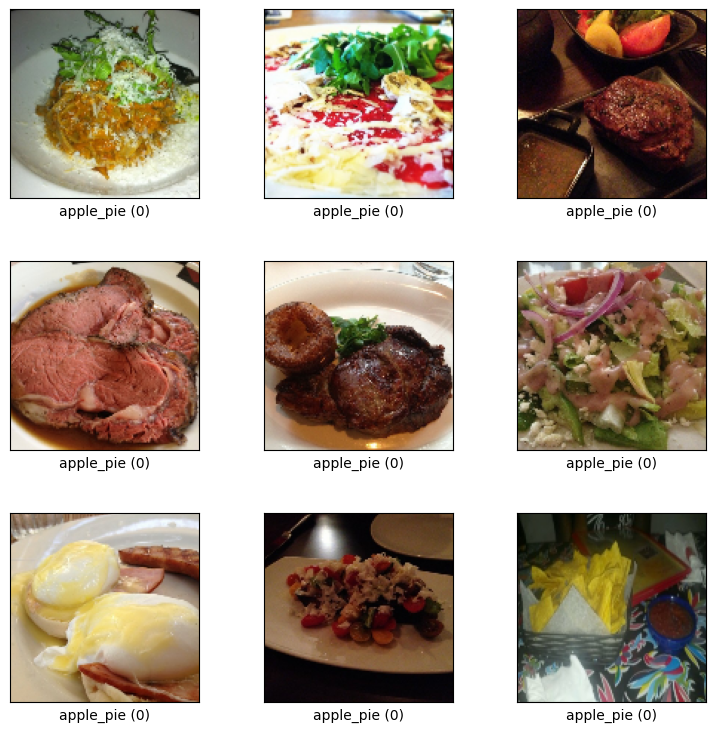

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
train_hd_side,valid_hd_side=750,250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)

# Filter the training dataset for not hot dogs
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [ ]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)

# Filter the training dataset for not hot dogs
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs,train_nothotdogs],[0.5,0.5],stop_on_empty_dataset=True)
train_ds=train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs,train_nothotdogs],[0.5,0.5],stop_on_empty_dataset=True)
valid_ds=valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch, label_batch in train_ds.take(1):
    # Print the shape of the image batch and label batch
    print(image_batch)
    print(label_batch)




tf.Tensor(
[[[[6.21568620e-01 5.31372547e-01 3.23529422e-01]
   [5.52941203e-01 4.62745100e-01 2.58823544e-01]
   [5.05882382e-01 4.19607848e-01 2.17647061e-01]
   ...
   [1.09803922e-01 9.01960805e-02 7.05882385e-02]
   [1.00000001e-01 8.03921595e-02 6.47058859e-02]
   [8.62745121e-02 6.86274543e-02 5.68627454e-02]]

  [[5.70588231e-01 4.84313726e-01 2.60784328e-01]
   [5.66666663e-01 4.80392158e-01 2.66666681e-01]
   [5.52941203e-01 4.70588237e-01 2.58823544e-01]
   ...
   [1.31372556e-01 1.11764707e-01 9.60784331e-02]
   [1.00000001e-01 8.23529437e-02 7.05882385e-02]
   [6.27451017e-02 4.70588244e-02 3.92156877e-02]]

  [[5.17647088e-01 4.35294122e-01 2.11764708e-01]
   [5.05882382e-01 4.23529416e-01 2.11764708e-01]
   [5.33333361e-01 4.50980395e-01 2.52941191e-01]
   ...
   [1.13725491e-01 9.80392173e-02 8.62745121e-02]
   [8.82352963e-02 7.25490227e-02 6.47058859e-02]
   [3.33333351e-02 2.35294122e-02 1.76470596e-02]]

  ...

  [[0.00000000e+00 1.88235298e-01 4.54901963e-01]
   [9

In [ ]:
plt.figure(figsize=(10, 10))

# Get one batch of images and labels from the validation dataset
for image_batch, label_batch in valid_ds.take(1):
    images = image_batch
    labels = label_batch




<Figure size 1000x1000 with 0 Axes>

In [ ]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)

])

In [ ]:
for i,_ in ds["train"]:
  image =i



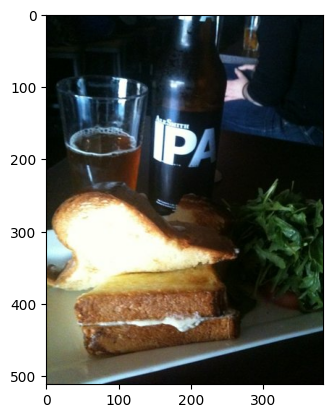

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.cast(tf.expand_dims(image,0),tf.float32)
image/=255.0

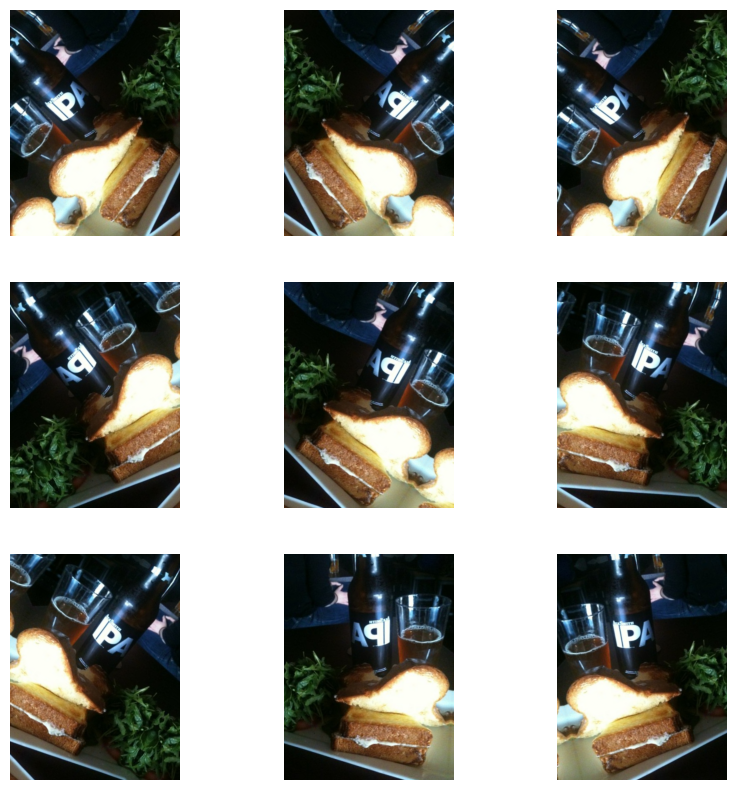

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image=data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")



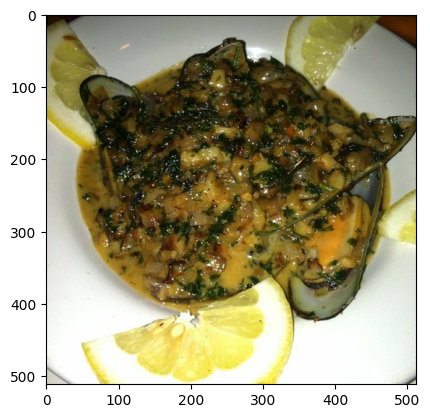

In [ ]:
for i,_ in ds["train"].take(1):
  image=i
plt.imshow(image)

In [ ]:
# Set random seed for reproducibility
random.seed(0)

# Define the model
model = models.Sequential()

# Add layers to the model
model.add(layers.Rescaling(1./255))  # Rescaling layer to normalize input images
model.add(data_augmentation)  # Ensure 'data_augmentation' is defined earlier

# First convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Corrected from .12 to .l2
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

# Third convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Corrected
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))  # Output layer for binary classification (hotdog vs not hotdog)

# Compile the model (optional, but usually done after defining the model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary (optional)



In [ ]:
lr=0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),  # Replace 0.001 with your desired learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)



In [ ]:
for images, labels in train_ds.take(1):
    print(images.shape)  # Should output something like (batch_size, 128, 128, 3)
    print(labels.shape)


(16, 128, 128, 3)
(16,)


In [ ]:
epochs=50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 512, 384, 3), found shape=(None, 128, 128, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=False, name=keras_tensor_36>',)
  • kwargs={'mask': 'None'}

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in valid_ds.take(1):
  images=image_batch
  labels=label_batch

<Figure size 1000x1000 with 0 Axes>

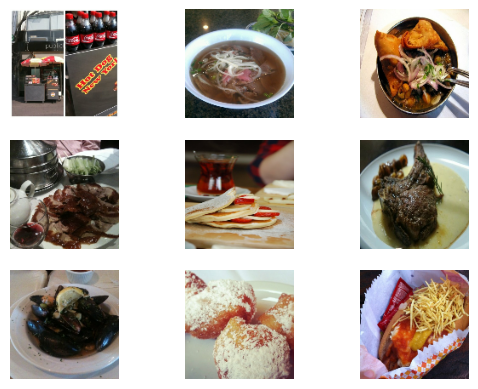

In [ ]:
for i in range(9):

  ax=plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [ ]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)>